In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt  
from sklearn.cluster import DBSCAN, AgglomerativeClustering

# import the vectorized data
df = pd.read_csv("output/clustering_2/vector_data.csv")
df.head()

,language,cast_0,director,genre_0,company_0,country,cast_num,crew_num,popularity
0,0,202,13,5,31,0,0,1,1.0
1,0,371,1212,13,584,6,0,0,0.0
2,26,1690,1956,5,1051,9,0,0,0.0
3,0,32,135,6,344,0,0,3,1.0
4,0,518,1793,8,942,0,0,1,0.0


In [34]:
pop = len([x for x in df['popularity'] if x == 1.0])
print("popular: ", pop)
print("not popular: ", len(df) - pop)

popular:  2393
not popular:  2397


# Compute Self-defined Metrics

## nominal and ordinal attributes

We have both nominal and ordinal attributes in the vectors.<br>
Similarity:
1. for nominal attribute, s = 1 if p == q, s = 0 if p != q
2. for ordinal attribute, s = 1 - abs(p - q)/(n - 1)
3. n: range of the mapping, in our case, n = 4
<br> 
This takes much longer time to compute. The difference is very little. In consideration of simplicity, we choose to use <b>SMC</b> to compute the metrics.

In [16]:
columns = ['language', 'cast_0', 'director', 'genre_0', 'company_0', 'country', 'cast_num', 'crew_num']
n = 4

# similarity matrix
simatrix = np.zeros((len(df), len(df)))
# distance matrix
dismatrix = np.zeros((len(df), len(df)))

def metrics(df):
    # for each row combination
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            # similarity vector of p and q
            s = []
            # nominal
            for col in columns[:6]:
                p = df.loc[i, col]
                q = df.loc[j, col]
                if p == q:
                    s.append(1)
                else:
                    s.append(0)
            # ordinal
            for col in columns[6:]:
                p = df.loc[i, col]
                q = df.loc[j, col]
                s.append(1 - abs(p - q)/(n - 1))
            # compute magnitude of the similarity vector, normalize
            mag = np.linalg.norm(s)/math.sqrt(8)
            # compute magnitude of the disimilarity vector, normalize
            magd = np.linalg.norm([(1 - x) for x in s ])/math.sqrt(8)
            # insert into similarity matrix
            simatrix[i][j] = mag
            simatrix[j][i] = mag
            # insert into dismatrix
            dismatrix[i][j] = magd
            dismatrix[j][i] = magd
        simatrix[i][i] = 1
        dismatrix[i][i] = 0

## SMC to compute metrics
treat all attributes as nominal attributes. Use SMC to do binary computation of similarity and disimilarity (distance)

In [17]:
columns = ['language', 'cast_0', 'director', 'genre_0', 'company_0', 'country', 'cast_num', 'crew_num']
n = len(columns)

# similarity matrix
simatrix = np.zeros((len(df), len(df)))
# distance( disimilarity) matrix
dismatrix = np.zeros((len(df), len(df)))

# simpler metrics computing method that only computes as nominal attribute
def metrics_simple(df):
    # for each row combination
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            # similarity vector of p and q
            s = 0
            # nominal
            for col in columns:
                p = df.loc[i, col]
                q = df.loc[j, col]
                if p == q:
                    s += 1
            # insert into similarity matrix
            simatrix[i][j] = s/n
            simatrix[j][i] = s/n
            # insert into dismatrix
            dismatrix[i][j] = (n-s)/n
            dismatrix[j][i] = (n-s)/n
        simatrix[i][i] = 1
        dismatrix[i][i] = 0
        # progress indicator
        if i%100 == 0:
            print(i, end = '...')

In [ ]:
# compute and export the similarity matrix into a csv file (only needed when the csv file needs to update)
metrics_simple(df)
pd.DataFrame(simatrix).to_csv('ch7_clustering/simatrix.csv', index=False)
pd.DataFrame(dismatrix).to_csv('ch7_clustering/dismatrix.csv', index=False)

# Implement Clustering Algorithms

In [2]:
dismatrix = pd.read_csv('ch7_clustering/dismatrix.csv', sep=',',header=None)

In [3]:
dismatrix = dismatrix.drop([0])
len(dismatrix)

4790

In [4]:
dismatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789
1,0.000,0.75,0.750,0.625,0.500,0.625,0.500,0.375,0.750,0.625,...,0.750,0.625,0.500,0.750,0.750,0.625,0.625,0.750,0.625,0.750
2,0.750,0.00,0.750,0.750,0.750,0.750,0.750,0.750,0.875,0.750,...,0.625,0.750,0.750,0.875,0.875,0.625,0.625,0.750,0.750,0.875
3,0.750,0.75,0.000,0.875,0.875,0.875,0.875,0.750,1.000,0.875,...,0.750,0.875,0.875,1.000,1.000,0.750,0.750,0.875,0.875,1.000
4,0.625,0.75,0.875,0.000,0.625,0.500,0.625,0.625,0.750,0.625,...,0.750,0.750,0.625,0.625,0.750,0.625,0.625,0.750,0.625,0.625
5,0.500,0.75,0.875,0.625,0.000,0.625,0.500,0.500,0.750,0.625,...,0.750,0.625,0.500,0.750,0.750,0.500,0.500,0.625,0.500,0.750


In [5]:
dismatrix = dismatrix.to_numpy()

## 1. DBScan

1. How to determine eps and min_samples?<br>
A low minPts means it will build more clusters from noise. One heuristic approach is use ln(n), where n is the total number of points to be clustered.
2. To determine elipson:<br>
<b>k-distance plot</b> <br>
In a clustering with minPts = k, we expect that core pints and border points' k-distance are within a certain range, while noise points can have much greater k-distance, thus we can observe a knee point in the k-distance plot. However, sometimes there may be no obvious knee, or there can be multiple knees, which makes it hard to decide

In [62]:
print(len(dismatrix))
np.log(4790)

4790


8.474285690404962

In [36]:
# use disimatrix (distance) computed by nominal
dbscan = DBSCAN(eps=0.374, min_samples=9, metric="precomputed").fit_predict(dismatrix)
print('eps=0.374\n', dbscan[:100])
print('number of clusters: ', max(dbscan) + 1)
print('number of noises: ', len([x for x in dbscan if x == -1]))

dbscan = DBSCAN(eps=0.375, min_samples=9, metric="precomputed").fit_predict(dismatrix)
print('eps=0.375\n', dbscan[:100])
print('number of clusters: ', max(dbscan) + 1)
print('number of noises: ', len([x for x in dbscan if x == -1]))

dbscan = DBSCAN(eps=0.38, min_samples=9, metric="precomputed").fit_predict(dismatrix)
print('eps=0.38\n', dbscan[:100])
print('number of clusters: ', max(dbscan) + 1)
print('number of noises: ', len([x for x in dbscan if x == -1]))

eps=0.374
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 11 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1  0 -1 -1 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1
 -1  0  0  0]
number of clusters:  13
number of noises:  4015
eps=0.375
 [ 0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0 -1  0  0 -1 -1  0  0  0  0  0  0  0 -1 -1  0  0  0 -1
  0 -1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0]
number of clusters:  1
number of noises:  639
eps=0.38
 [ 0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0 -1  0  0 -1 -1  0  0  0  0  0  0  0 -1 -1  0  0  0 -1
  0 -1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0 

As observed above, values after 0.374 gives us one single big cluster. Our goal is to divide as much of the data into moderate number of clusters. If we can approach our goal to divide them into two reasonable clusters and fit into (popular, non-popular), it would be best.  
<br>We choose eps = 0.374, then try different min_samples

In [37]:
# use disimatrix (distance) computed by nominal
dbscan = DBSCAN(eps=0.374, min_samples=8, metric="precomputed").fit_predict(dismatrix)
print('min_samples=8\n', dbscan[:100])
print('number of clusters: ', max(dbscan))
print('number of noises: ', len([x for x in dbscan if x == -1]))

dbscan = DBSCAN(eps=0.374, min_samples=9, metric="precomputed").fit_predict(dismatrix)
print('min_samples=9\n', dbscan[:100])
print('number of clusters: ', max(dbscan))
print('number of noises: ', len([x for x in dbscan if x == -1]))

dbscan = DBSCAN(eps=0.374, min_samples=13, metric="precomputed").fit_predict(dismatrix)
print('min_samples=10\n', dbscan[:100])
print('number of clusters: ', max(dbscan))
print('number of noises: ', len([x for x in dbscan if x == -1]))

min_samples=8
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  8 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 13 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1  0 -1 -1 -1 -1 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  0
  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0  0 -1
 -1  0  0  0]
number of clusters:  14
number of noises:  3900
min_samples=9
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 11 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1  0 -1 -1 -1 -1  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0 -1 -1
 -1  0  0  0]
number of clusters:  12
number of noises:  4015
min_samples=10
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
  2 -1 -1 -1 -1  0 -1 -1 -1

In [44]:
dbscan = DBSCAN(metric="precomputed").fit_predict(dismatrix)
print('default\n', dbscan[:100])
print('number of clusters: ', max(dbscan) + 1)
print('cluster 0: ', len([x for x in dbscan if x == 0]))
print('cluster 1: ', len([x for x in dbscan if x == 1]))
print('cluster 2: ', len([x for x in dbscan if x == 2]))
print('number of noises: ', len([x for x in dbscan if x == -1]))

default
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
number of clusters:  3
cluster 0:  4732
cluster 1:  5
cluster 2:  7
number of noises:  46


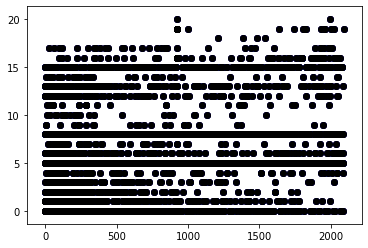

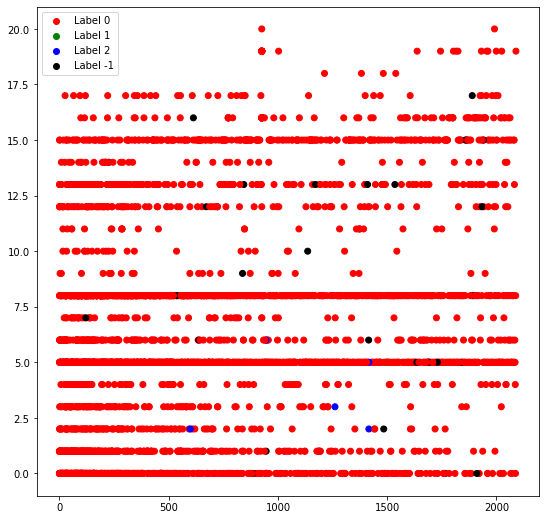

In [14]:
# visualization on df['cast_0'], df['genre_0']

# default
dbscan = DBSCAN(metric="precomputed").fit(dismatrix)
labels = dbscan.labels_ 
# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
# For the construction of the legend of the plot 
r = plt.scatter(df['cast_0'], df['genre_0'], color ='r'); 
g = plt.scatter(df['cast_0'], df['genre_0'], color ='g'); 
b = plt.scatter(df['cast_0'], df['genre_0'], color ='b');
k = plt.scatter(df['cast_0'], df['genre_0'], color ='k'); 
# Plotting cast_0 on the X-Axis and genre_0 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(df['cast_0'], df['genre_0'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 

As shown above, no matter which set of parameter we chose, clusering using DBSCAN gives us either <b>a super cluster</b> or <b>too many noise points</b>.

### Conclusion:
<br>DBSCAN is not a good method to cluster our dataset. The reason might be that the features in our dataset are mostly categorical instead of numerical. And when computing similarity, SMC is used. The dissimilarity is used as disttance. However, it is not strictly a metric because it does not satisfy <b>Triangle Inequality</b>.
<br>The dataset have both high density and low density. The rather low density data are all mistaken as noise points.
<br>To sum up, DBSCAN, a clustering method used to separate clusters of high density from noise points, is not suitable for our data.

## 2. Agglomerative

In [50]:
agglo = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average').fit_predict(dismatrix)
print('default\n', agglo[:100])
print('number of clusters: ', max(agglo) + 1)
print('cluster 0', len([x for x in agglo if x == 0]))
print('cluster 1', len([x for x in agglo if x == 1]))

default
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of clusters:  2
cluster 0 5
cluster 1 4785


In [41]:
# accuracy of the agglomerative clustering
# if cluster 1 = popular, 0 = unpopular
ppl = df['popularity']
count = 0
for i in range(len(df)):
    if agglo[i] == int(ppl[i]):
        count += 1
print(count/len(df))

0.4997912317327766


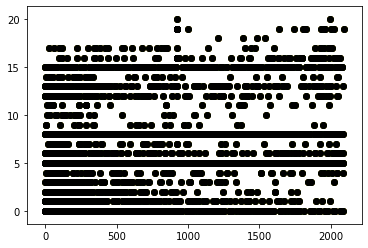

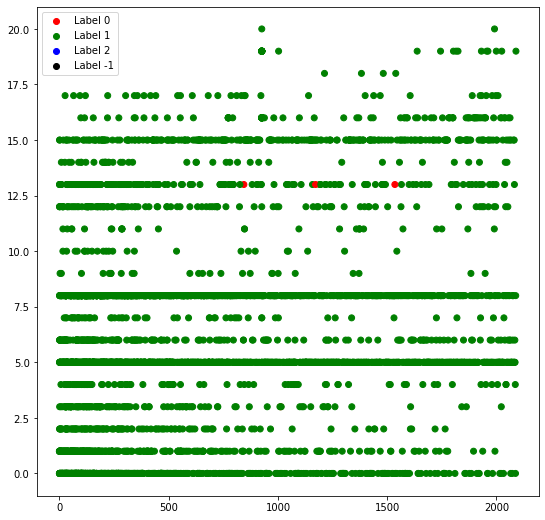

In [15]:
# visualization on df['cast_0'], df['genre_0']

# default
agglo = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average').fit(dismatrix)
labels = agglo.labels_ 
# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[-1] = 'k'
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
# For the construction of the legend of the plot 
r = plt.scatter(df['cast_0'], df['genre_0'], color ='r'); 
g = plt.scatter(df['cast_0'], df['genre_0'], color ='g'); 
k = plt.scatter(df['cast_0'], df['genre_0'], color ='k'); 
# Plotting cast_0 on the X-Axis and genre_0 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(df['cast_0'], df['genre_0'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 